# Data 70:30

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2
from google.colab import drive
import random


In [20]:
# Mount Google Drive (uncomment jika diperlukan untuk Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Configuration variables
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.00001

In [22]:
# Tetapkan seed global
def set_seed(seed_value):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

# Tetapkan seed
set_seed(42)

In [23]:
# Konfigurasi path data
DATA_DIR = '/content/drive/MyDrive/TA'  # direktori utama dataset
KARIES_DIR = os.path.join(DATA_DIR, 'database2/karies')  # direktori gambar karies
SEHAT_DIR = os.path.join(DATA_DIR, 'database2/sehat')   # direktori gambar sehat
PROCESSED_DIR = os.path.join(DATA_DIR, 'dt2/individual')  # direktori hasil preprocessing

In [24]:
# ===== AWAL PEMERIKSAAN DATA =====
# Memeriksa jumlah gambar di setiap folder
jumlah_karies = len(os.listdir(KARIES_DIR))
jumlah_sehat = len(os.listdir(SEHAT_DIR))

print(f"Jumlah gambar karies: {jumlah_karies}")
print(f"Jumlah gambar sehat: {jumlah_sehat}")

Jumlah gambar karies: 244
Jumlah gambar sehat: 381


#Preprocessing Gambar

In [ ]:
def preprocess_image(img_path, output_path=None, denoise=True, clahe=True, save=False):
    """
    Fungsi untuk preprocessing gambar panoramik gigi

    Parameters:
    - img_path: Path ke gambar input
    - output_path: Path untuk menyimpan gambar hasil preprocessing (opsional)
    - denoise: Apakah menerapkan denoising
    - clahe: Apakah menerapkan Contrast Limited Adaptive Histogram Equalization
    - save: Apakah menyimpan hasil preprocessing

    Returns:
    - img_processed: Gambar yang telah diproses
    """
    # Baca gambar
    img = cv2.imread(img_path)

    if img is None:
        print(f"Error: Tidak dapat membaca gambar dari {img_path}")
        return None

    # Konversi ke grayscale jika gambar berwarna
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img

    # Menerapkan denoising untuk mengurangi noise
    if denoise:
        img_gray = cv2.fastNlMeansDenoising(img_gray, None, 10, 7, 21)

    # Menerapkan CLAHE untuk meningkatkan kontras
    if clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_processed = clahe.apply(img_gray)
    else:
        img_processed = img_gray

    # Menyimpan hasil preprocessing jika diperlukan
    if save and output_path:
        cv2.imwrite(output_path, img_processed)

    return img_processed

In [ ]:
# Fungsi untuk preprocessing batch gambar (dapat dijalankan secara opsional)
def batch_preprocess(input_dir, output_dir):
    """
    Memproses semua gambar dalam direktori dan menyimpan hasil
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    files = os.listdir(input_dir)
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            input_path = os.path.join(input_dir, file)
            output_path = os.path.join(output_dir, file)
            preprocess_image(input_path, output_path, save=True)
            print(f"Preprocessed: {file}")


In [ ]:
# CATATAN: Uncomment baris di bawah jika ingin melakukan preprocessing manual
batch_preprocess(KARIES_DIR, os.path.join(PROCESSED_DIR, 'processed_karies'))
batch_preprocess(SEHAT_DIR, os.path.join(PROCESSED_DIR, 'processed_sehat'))

Preprocessed: 20250507_145913.jpg
Preprocessed: 161.jpg
Preprocessed: 436.jpg
Preprocessed: 354.jpg
Preprocessed: 182.jpg
Preprocessed: 278.jpg
Preprocessed: 408.jpg
Preprocessed: 13.jpg
Preprocessed: 476.jpg
Preprocessed: 515.jpg
Preprocessed: 579.jpg
Preprocessed: 522.jpg
Preprocessed: 173.jpg
Preprocessed: 384.jpg
Preprocessed: 434.jpg
Preprocessed: 297.jpg
Preprocessed: 43.jpg
Preprocessed: 115.jpg
Preprocessed: 584.jpg
Preprocessed: 6.jpg
Preprocessed: 20250507_153128.jpg
Preprocessed: 551.jpg
Preprocessed: 572.jpg
Preprocessed: 375.jpg
Preprocessed: 192.jpg
Preprocessed: 20250507_153334.jpg
Preprocessed: 335.jpg
Preprocessed: 273.jpg
Preprocessed: 327.jpg
Preprocessed: 191.jpg
Preprocessed: 556.jpg
Preprocessed: 489.jpg
Preprocessed: 292.jpg
Preprocessed: 235.jpg
Preprocessed: 225.jpg
Preprocessed: 308.jpg
Preprocessed: 211.jpg
Preprocessed: 402.jpg
Preprocessed: 20250507_154131.jpg
Preprocessed: 20250507_154117.jpg
Preprocessed: 506.jpg
Preprocessed: 323.jpg
Preprocessed: 202505

#Preprocessing Data

In [25]:
# ===== BAGIAN PRE-PROCESSING DATA =====
# Membuat generator data dengan augmentasi untuk data training
# Preprocessing meliputi:
# 1. Rescaling - Normalisasi nilai piksel dari 0-255 menjadi 0-1
# 2. Augmentasi data - Meningkatkan variasi data training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi nilai piksel
    validation_split=0.3,  # 30% data untuk validasi
    rotation_range=20,  # Rotasi gambar hingga 20 derajat
    width_shift_range=0.2,  # Pergeseran horizontal
    height_shift_range=0.2,  # Pergeseran vertikal
    shear_range=0.2,  # Transformasi shear
    zoom_range=0.2,  # Zoom in/out
    horizontal_flip=True,  # Refleksi horizontal
    fill_mode='nearest',  # Strategi mengisi piksel baru
    # brightness_range=[0.8, 1.2]  # Variasi kecerahan (opsional untuk menangani kontras berbeda)
)


In [26]:
# Generator untuk data validasi (hanya rescaling)
validation_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi nilai piksel
    validation_split=0.3  # 20% data untuk validasi
)

In [27]:
# Memuat data dan menerapkan preprocessing
# target_size - Mengubah ukuran semua gambar menjadi 224x224 piksel (preprocessing ukuran)
train_generator = train_datagen.flow_from_directory(
    PROCESSED_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize gambar ke ukuran standar
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Klasifikasi biner: karies atau sehat
    subset='training',
    shuffle=True,  # Mengacak data untuk training
    seed=42
)

# Memuat data validasi
validation_generator = validation_datagen.flow_from_directory(
    PROCESSED_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize gambar ke ukuran standar
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,  # Tidak mengacak data validasi
    seed=42
)


Found 438 images belonging to 2 classes.
Found 187 images belonging to 2 classes.


# Building Model

In [28]:
# Membangun model CNN
model = models.Sequential([
    # Layer konvolusi pertama
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Layer konvolusi kedua
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Layer konvolusi ketiga
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Layer konvolusi keempat
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Layer flatten untuk mengubah menjadi format 1D
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout untuk mengurangi overfitting
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),

    # Layer output
    layers.Dense(1, activation='sigmoid')  # sigmoid untuk klasifikasi biner
])

In [29]:
# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [30]:
tf.keras.utils.set_random_seed(42)

In [31]:
# Ringkasan model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,212,545 (99.99 MB)

 Trainable params: 26,211,585 (99.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [32]:
# Callbacks untuk training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

In [33]:
# Menyimpan model terbaik
checkpoint_filepath = '/content/drive/MyDrive/TA/database2/hasilta5/model_karies_gigi.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [34]:
# Melatih model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4937 - loss: 0.9929
Epoch 1: val_accuracy improved from -inf to 0.60963, saving model to /content/drive/MyDrive/TA/database2/hasilta5/model_karies_gigi.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 124s 8s/step - accuracy: 0.4958 - loss: 0.9896 - val_accuracy: 0.6096 - val_loss: 0.6920
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5870 - loss: 0.8317
Epoch 2: val_accuracy did not improve from 0.60963
14/14 ━━━━━━━━━━━━━━━━━━━━ 96s 7s/step - accuracy: 0.5883 - loss: 0.8302 - val_accuracy: 0.3904 - val_loss: 0.6946
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6592 - loss: 0.7384
Epoch 3: val_accuracy did not improve from 0.60963
14/14 ━━━━━━━━━━━━━━━━━━━━ 87s 6s/step - accuracy: 0.6574 - loss: 0.7402 - val_accuracy: 0.4011 - val_loss: 0.6943
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6580 - loss: 0.6501
Epoch 4: val_accuracy did not improve from 0.60963
14/14 ━━━━━━━━━━━━━━━━━━━━ 142s 6s/step - accuracy: 0.6569 - loss: 0.6527 - val_accuracy: 0.6096 - val_loss: 0.6877
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6557 - loss: 0.7044
Epoch 5: val_accuracy did not improve from 0.60963
14

14/14 ━━━━━━━━━━━━━━━━━━━━ 92s 7s/step - accuracy: 0.7173 - loss: 0.6083 - val_accuracy: 0.6150 - val_loss: 0.7563
Epoch 38/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7432 - loss: 0.5044
Epoch 38: val_accuracy improved from 0.61497 to 0.62567, saving model to /content/drive/MyDrive/TA/database2/hasilta5/model_karies_gigi.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - accuracy: 0.7424 - loss: 0.5066 - val_accuracy: 0.6257 - val_loss: 0.7050
Epoch 39/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7429 - loss: 0.5445
Epoch 39: val_accuracy improved from 0.62567 to 0.64171, saving model to /content/drive/MyDrive/TA/database2/hasilta5/model_karies_gigi.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.7414 - loss: 0.5457 - val_accuracy: 0.6417 - val_loss: 0.6785
Epoch 40/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7534 - loss: 0.5051
Epoch 40: val_accuracy improved from 0.64171 to 0.64706, saving model to /content/drive/MyDrive/TA/database2/hasilta5/model_karies_gigi.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 137s 6s/step - accuracy: 0.7540 - loss: 0.5049 - val_accuracy: 0.6471 - val_loss: 0.6632
Epoch 41/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7440 - loss: 0.5077
Epoch 41: val_accuracy improved from 0.64706 to 0.66310, saving model to /content/drive/MyDrive/TA/database2/hasilta5/model_karies_gigi.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 103s 7s/step - accuracy: 0.7439 - loss: 0.5088 - val_accuracy: 0.6631 - val_loss: 0.6250
Epoch 42/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7677 - loss: 0.5293
Epoch 42: val_accuracy improved from 0.66310 to 0.66845, saving model to /content/drive/MyDrive/TA/database2/hasilta5/model_karies_gigi.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 111s 8s/step - accuracy: 0.7667 - loss: 0.5289 - val_accuracy: 0.6684 - val_loss: 0.6152
Epoch 43/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7333 - loss: 0.5339
Epoch 43: val_accuracy did not improve from 0.66845
14/14 ━━━━━━━━━━━━━━━━━━━━ 96s 7s/step - accuracy: 0.7327 - loss: 0.5353 - val_accuracy: 0.6684 - val_loss: 0.6307
Epoch 44/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7681 - loss: 0.5291
Epoch 44: val_accuracy did not improve from 0.66845
14/14 ━━━━━━━━━━━━━━━━━━━━ 131s 6s/step - accuracy: 0.7672 - loss: 0.5293 - val_accuracy: 0.6417 - val_loss: 0.6606
Epoch 45/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7701 - loss: 0.4990
Epoch 45: val_accuracy improved from 0.66845 to 0.67914, saving model to /content/drive/MyDrive/TA/database2/hasilta5/model_karies_gigi.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 89s 6s/step - accuracy: 0.7684 - loss: 0.5014 - val_accuracy: 0.6791 - val_loss: 0.6013
Epoch 46/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7488 - loss: 0.5276
Epoch 46: val_accuracy improved from 0.67914 to 0.73797, saving model to /content/drive/MyDrive/TA/database2/hasilta5/model_karies_gigi.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 146s 7s/step - accuracy: 0.7498 - loss: 0.5260 - val_accuracy: 0.7380 - val_loss: 0.5603
Epoch 47/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7664 - loss: 0.4678
Epoch 47: val_accuracy did not improve from 0.73797
14/14 ━━━━━━━━━━━━━━━━━━━━ 95s 7s/step - accuracy: 0.7651 - loss: 0.4716 - val_accuracy: 0.7166 - val_loss: 0.5750
Epoch 48/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7552 - loss: 0.5271
Epoch 48: val_accuracy did not improve from 0.73797
14/14 ━━━━━━━━━━━━━━━━━━━━ 97s 7s/step - accuracy: 0.7544 - loss: 0.5275 - val_accuracy: 0.7380 - val_loss: 0.5352
Epoch 49/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7134 - loss: 0.5366
Epoch 49: val_accuracy improved from 0.73797 to 0.75936, saving model to /content/drive/MyDrive/TA/database2/hasilta5/model_karies_gigi.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 90s 7s/step - accuracy: 0.7138 - loss: 0.5375 - val_accuracy: 0.7594 - val_loss: 0.5208
Epoch 50/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7234 - loss: 0.5268
Epoch 50: val_accuracy did not improve from 0.75936
14/14 ━━━━━━━━━━━━━━━━━━━━ 139s 6s/step - accuracy: 0.7254 - loss: 0.5258 - val_accuracy: 0.7380 - val_loss: 0.5434


#Evaluation

In [35]:
# Menampilkan hasil terbaik dari training
best_val_acc_idx = np.argmax(history.history['val_accuracy'])
best_train_acc = history.history['accuracy'][best_val_acc_idx]
best_val_acc = history.history['val_accuracy'][best_val_acc_idx]
best_epoch = best_val_acc_idx + 1

print("\nHasil Terbaik dari Training:")
print(f"Epoch terbaik: {best_epoch}")
print(f"Akurasi training terbaik: {best_train_acc:.4f}")
print(f"Akurasi validasi terbaik: {best_val_acc:.4f}")


Hasil Terbaik dari Training:
Epoch terbaik: 49
Akurasi training terbaik: 0.7192
Akurasi validasi terbaik: 0.7594


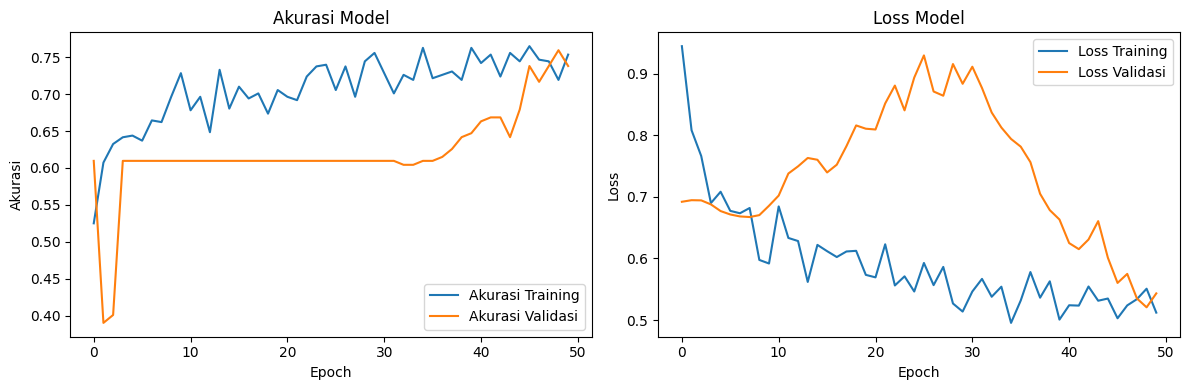

In [36]:
# Visualisasi hasil training
plt.figure(figsize=(12, 4))

# Plot akurasi training dan validasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot loss training dan validasi
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/TA/database2/hasilta5/training_history.png')
plt.show()

In [37]:
# Evaluasi model pada data validasi
validation_generator.reset()
y_pred_probs = model.predict(validation_generator)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = validation_generator.classes

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


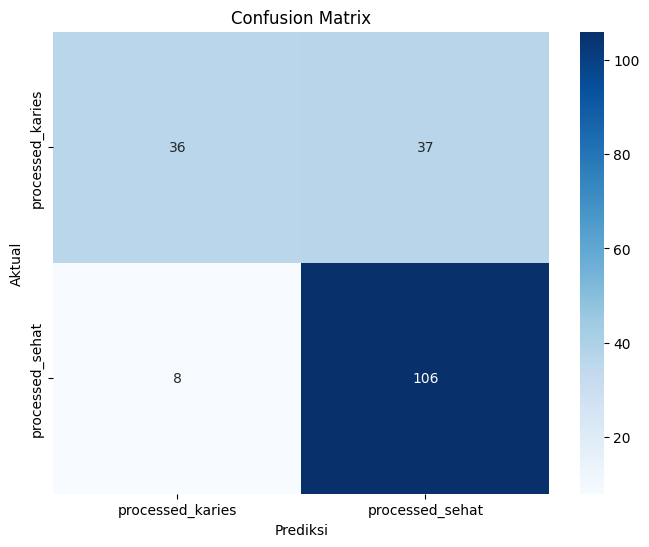

In [38]:
# Hitung dan tampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(validation_generator.class_indices.keys()),
            yticklabels=list(validation_generator.class_indices.keys()))
plt.title('Confusion Matrix')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.savefig('/content/drive/MyDrive/TA/database2/hasilta5/confusion_matrix.png')
plt.show()

In [39]:
# Cetak laporan klasifikasi
print("\nLaporan Klasifikasi:")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(validation_generator.class_indices.keys())
))


Laporan Klasifikasi:
                  precision    recall  f1-score   support

processed_karies       0.82      0.49      0.62        73
 processed_sehat       0.74      0.93      0.82       114

        accuracy                           0.76       187
       macro avg       0.78      0.71      0.72       187
    weighted avg       0.77      0.76      0.74       187



In [40]:
# Menyimpan model final
model.save('/content/drive/MyDrive/TA/database2/hasilta5/model_karies_gigi_final.h5')